In [ ]:
def create_box(box_count):
    

In [ ]:
import random

# Define constants
NUM_FARMERS = 100
NUM_TEST_STAGES = 4
F_TEST_RATE = 0.2
P_TEST_RATE = 0.1
D_TEST_RATE = 0.05
C_TEST_RATE = 0.01
EFFORT_RANGE = (0, 1)
TECH_RANGE = (0, 1)
SOCIAL_RANGE = (0, 1)
PENALTY_RANGE = (0, 1)
MAX_BOXES_PER_DIST = 1000
NUM_CUSTOMERS = 100
CUSTOMER_DEMAND = 10

# Define variables
f_test_history = [[[0 for _ in range(NUM_TEST_STAGES)] for _ in range(MAX_BOXES_PER_DIST)] for _ in range(NUM_FARMERS)]
p_test_history = [[[0 for _ in range(NUM_TEST_STAGES)] for _ in range(MAX_BOXES_PER_DIST)] for _ in range(NUM_FARMERS)]
d_test_history = [[[0 for _ in range(NUM_TEST_STAGES)] for _ in range(MAX_BOXES_PER_DIST)] for _ in range(NUM_FARMERS)]
c_test_history = [[[0 for _ in range(NUM_TEST_STAGES)] for _ in range(MAX_BOXES_PER_DIST)] for _ in range(NUM_CUSTOMERS)]
farmers = []
distributors = []
retailers = []
customers = []
transport_costs = []
contaminate_drop = []
f_to_p_box = []
p_to_d_box = []
d_to_r_box = []
r_to_c_box = []

# Define helper functions
def generate_random_number():
    return random.random()

def generate_random_binary(prob):
    return 1 if generate_random_number() < prob else 0

def is_box_contaminated(box_id, test_history, test_rate):
    return test_history[box_id][-1] == 1 or generate_random_binary(test_rate)

def get_contaminated_boxes(box_ids, test_history):
    contaminated_boxes = []
    for box_id in box_ids:
        if test_history[box_id][-1] == 1:
            contaminated_boxes.append(box_id)
    return contaminated_boxes

def get_box_plot(box_id):
    return box_id % 10

def get_transport_cost(distance):
    return distance * 0.1

def initialize_farmers():
    for i in range(NUM_FARMERS):
        farmers.append({
            "id": i,
            "effort": random.uniform(*EFFORT_RANGE),
            "technology": random.uniform(*TECH_RANGE),
            "social_connectedness": [random.uniform(*SOCIAL_RANGE) for _ in range(NUM_FARMERS)],
            "penalty": random.uniform(*PENALTY_RANGE)
        })

def initialize_distributors():
    for i in range(NUM_FARMERS):
        distributors.append({
            "id": i,
            "cur_box_count": 0
        })

def initialize_retailers():
    for i in range(NUM_CUSTOMERS):
        retailers.append({
            "id": i,
            "boxes": [],
            "demand": CUSTOMER_DEMAND
        })

def farm_testing_stage():
    # Generate f_test_numbers for all boxes
    f_test_numbers = [generate_random_number() for _ in range(MAX_BOXES_PER_DIST)]

    # Determine which boxes are contaminated
    f_test_contaminated_boxes = [1 if f_test_numbers[i] < F_TEST_RATE else 0 for i in range(MAX_BOXES_PER_DIST)]

    # Update f_test_history matrix
    for i in range(MAX_BOXES_PER_DIST):
        f_test_history[i][-1][0] = f_test_contaminated_boxes[i]

    # Find location of contaminated boxes and mark all
    for i in range(NUM_FARMERS):
        farmer = farmers[i]
        contaminated_boxes = get_contaminated_boxes(farmer["boxes"], f_test_history[i], F_TEST_RATE)
    for box_id in contaminated_boxes:
        f_to_p_box.append((i, box_id))

# Generate p_test_numbers for all boxes held by distributors
def distributor_testing_stage():
    p_test_numbers = [generate_random_number() for _ in range(sum([distributor["cur_box_count"] for distributor in distributors]))]
    # Determine which boxes are contaminated
    p_test_contaminated_boxes = [1 if p_test_numbers[i] < P_TEST_RATE else 0 for i in range(len(p_test_numbers))]

    # Update p_test_history matrix
    box_idx = 0
    for i in range(NUM_FARMERS):
        for j in range(distributors[i]["cur_box_count"]):
            p_test_history[i][j][-1] = p_test_contaminated_boxes[box_idx]
            box_idx += 1

    # Find location of contaminated boxes and mark all as such in the p_to_d_box list
    for i in range(NUM_FARMERS):
        distributor = distributors[i]
        start_idx = sum([distributors[j]["cur_box_count"] for j in range(i)])
        end_idx = start_idx + distributor["cur_box_count"]
        contaminated_boxes = get_contaminated_boxes(range(start_idx, end_idx), p_test_history[i])
        for box_id in contaminated_boxes:
            p_to_d_box.append((i, box_id))

# Generate d_test_numbers for all boxes held by retailers
def retailer_testing_stage():
    d_test_numbers = [generate_random_number() for _ in range(sum([len(retailer["boxes"]) for retailer in retailers]))]

    # Determine which boxes are contaminated
    d_test_contaminated_boxes = [1 if d_test_numbers[i] < D_TEST_RATE else 0 for i in range(len(d_test_numbers))]

    # Update d_test_history matrix
    box_idx = 0
    for retailer in retailers:
        for i in range(len(retailer["boxes"])):
            d_test_history[retailer["boxes"][i]][-1] = d_test_contaminated_boxes[box_idx]
            box_idx += 1

    # Find location of contaminated boxes and mark all as such in the d_to_r_box list
    for i in range(NUM_CUSTOMERS):
        retailer = retailers[i]
        contaminated_boxes = get_contaminated_boxes(retailer["boxes"], d_test_history)
        for box_id in contaminated_boxes:
            d_to_r_box.append((i, box_id))
    
# Generate c_test_numbers for all customers
def customer_testing_stage():
    c_test_numbers = [generate_random_number() for _ in range(NUM_CUSTOMERS)]

    # Determine which boxes are contaminated
    c_test_contaminated_boxes = [1 if c_test_numbers[i] < C_TEST_RATE else 0 for i in range(NUM_CUSTOMERS)]

    # Update c_test_history matrix
    for i in range(NUM_CUSTOMERS):
        c_test_history[i][-1] = c_test_contaminated_boxes[i]

    # Find location of contaminated boxes and mark all as such in the r_to_c_box list
    for i in range(NUM_CUSTOMERS):
        if c_test_history[i][-1] == 1:
            for box_id in retailers[i]["boxes"]:
                r_to_c_box.append((i, box_id))
                
def update_distributor_inventory():
    for i in range(NUM_FARMERS):
        for j in range(len(farmers[i]["boxes"])):
            if (i, j) not in f_to_p_box:
                distributors[i]["cur_box_count"] += 1
    for i in range(NUM_FARMERS):
        for j in range(len(d_test_history[i])):
            if d_test_history[i][j][-1] == 0 and (i, j) not in p_to_d_box:
                retailers[i]["



Please do a code in python. Use numpy and Numba wherever possible and make the code as fastest as it can be. 

Box IDs should be in a list. Help me create an unique ID for each box helping to identify farm and plot. The boxes are run in five stages F, P, D, R, C and we need to be able to identify each box at each stage so make sure to include this also in ID. We have farm_population farms, with each having plot_per_farm plots. Each plot has box_per_plot boxes.

Set some of the boxes as contaminated boxes determined by contamination_rate is the fraction of the boxes are contaminated. 

In F stage of testing, testing rate is f_test_rate, and f_test_rate determines number of boxes tested randomly from all the boxes, if the tested box is a contaminated one, its ID should be noted and it should be dropped alongwith all the other boxes in the same plot as the tested contaminated box. Removed boxes have to be noted at each stagefor reporting. All the non-tested boxes and non-contaminated tested boxes will proceed to next stage of testing. 

The remaining boxes pass on to P stage, D stage and R stage of testing, where we have a similar testing until the end. 

In [56]:
import random

farm_population = 100
plot_per_farm = 50
box_per_plot = 200
contamination_rate = 0.05
f_test_rate = 0.1

# Create box IDs
boxes = []
for farm in range(1, farm_population + 1):
    for plot in range(1, plot_per_farm + 1):
        for box in range(1, box_per_plot + 1):
            box_id = f"{farm}_{plot}_{box}"
            boxes.append(box_id)

# Set some of the boxes as contaminated boxes
contaminated_boxes = random.sample(boxes, int(len(boxes) * contamination_rate))

# F stage of testing
tested_boxes_f = random.sample(boxes, int(len(boxes) * f_test_rate))
for box in tested_boxes_f:
    if box in contaminated_boxes:
        # Drop all boxes in the same plot as the contaminated box
        farm, plot, _ = box.split("_")
        for b in boxes:
            if b.startswith(f"{farm}_{plot}_"):
                boxes.remove(b)
        
# P, D, and R stages of testing
for stage in ["P", "D", "R"]:
    tested_boxes = random.sample(boxes, int(len(boxes) * f_test_rate))
    for box in tested_boxes:
        if box in contaminated_boxes:
            # Drop all boxes in the same plot as the contaminated box
            farm, plot, _ = box.split("_")
            for b in boxes:
                if b.startswith(f"{farm}_{plot}_"):
                    boxes.remove(b)
                    
# C stage of testing
tested_boxes_c = boxes


KeyboardInterrupt: 

In [55]:
tested_boxes[1].split("_")

['8', '3', '6']

In [30]:
farm_population = 10
plot_per_farm = 5
box_per_plot = 20

# Initialize an empty list to store the box IDs
box_ids = []

# Loop over each farm, plot, and box
for farm in range(1, farm_population + 1):
    for plot in range(1, plot_per_farm + 1):
        for box in range(1, box_per_plot + 1):
            
            # Generate the unique box ID
            box_id = f'F{farm:02d}P{plot:02d}D{box:03d}'
            
            # Add the box ID for each stage to the list
            
            for stage in ['F', 'P', 'D', 'R', 'C']:
                full_id = f'{box_id}{stage}'
                box_ids.append(full_id)
len(box_ids)

5000

In [50]:
import random

# Parameters
farm_population = 10
plot_per_farm = 5
box_per_plot = 20
contamination_rate = 10
f_test_rate = 0.2
p_test_rate = 0.3

# Generate unique box IDs
box_ids = []
for farm_id in range(farm_population):
    for plot_id in range(plot_per_farm):
        for box_id in range(box_per_plot):
            box_ids.append(f"B{box_id:02d}P{plot_id:02d}F{farm_id:02d}")

# Simulate testing
tested_boxes = []
contaminated_boxes = set()
for box_id in box_ids:
    # F stage testing
    if random.random() < f_test_rate:
        tested_boxes.append(box_id)
        if box_id in contaminated_boxes:
            # Remove all boxes in the same plot as the contaminated box
            contaminated_plot = box_id[:5]  # "BXXPXX"
            contaminated_boxes.update(
                [b for b in box_ids if b.startswith(contaminated_plot)]
            )
        else:
            # P stage testing
            if random.random() < p_test_rate:
                tested_boxes.append(box_id)
                if box_id in contaminated_boxes:
                    # Remove all boxes in the same plot as the contaminated box
                    contaminated_plot = box_id[:5]  # "BXXPXX"
                    contaminated_boxes.update(
                        [b for b in box_ids if b.startswith(contaminated_plot)]
                    )
                else:
                    # Box passed testing
                    pass
            else:
                # Box passed testing
                pass
    else:
        # Box passed testing
        pass

print(f"Number of tested boxes: {len(tested_boxes)}")
print(f"Number of contaminated boxes: {len(contaminated_boxes)}")


Number of tested boxes: 257
Number of contaminated boxes: 0


In [42]:
import numpy as np

customer_number = 100
customer_demand = np.floor(np.abs(np.random.normal(1, 2, size=(customer_number,))))
customer_demand

array([0., 2., 0., 2., 0., 0., 1., 1., 1., 1., 0., 0., 6., 5., 2., 3., 0.,
       0., 6., 2., 1., 0., 0., 2., 2., 0., 2., 5., 1., 0., 2., 3., 0., 1.,
       4., 1., 1., 3., 2., 4., 0., 1., 0., 0., 2., 0., 2., 1., 3., 4., 0.,
       2., 1., 4., 0., 1., 3., 0., 1., 3., 2., 0., 5., 1., 0., 0., 3., 2.,
       1., 1., 0., 2., 2., 1., 1., 1., 1., 2., 3., 1., 4., 1., 0., 0., 2.,
       0., 1., 0., 1., 4., 2., 0., 3., 4., 2., 0., 0., 1., 0., 2.])

In [43]:
customer_demand[13]

5.0

In [14]:
import math


farm_population=1
plot_per_farm=10
box_per_plot=10

#box_id = [i * 10000 + j for i in range(1, farm_population + 1) for j in range(1, plot_per_farm + 1) for _ in range(1, box_per_plot + 1)]
box_id=[]

num_boxes=farm_population*plot_per_farm*box_per_plot
digits = int(math.log10(num_boxes))+1



for i in range(1, farm_population + 1):
    for j in range(1, plot_per_farm + 1):
        for _ in range(1, box_per_plot + 1):
            box_id.append(i * 10000 + j)

print(len(box_id))
box_id[-4]



100


10010

In [17]:
n=93248683

print(digits)

8


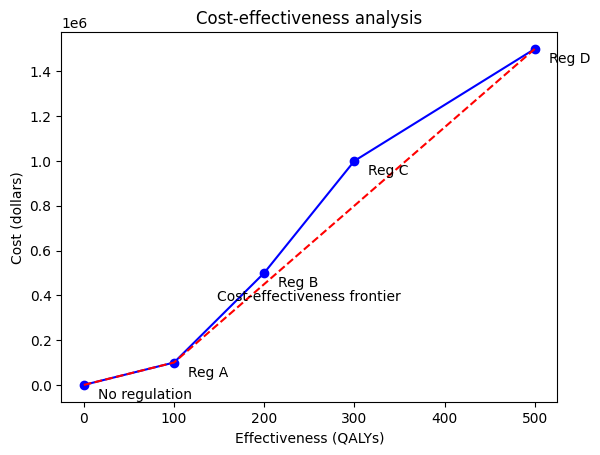

In [27]:
import matplotlib.pyplot as plt

treatments = ["No regulation", "Reg A", "Reg B", "Reg C", "Reg D"]
costs = [0, 100000, 500000, 1000000, 1500000]
effectiveness = [0, 100, 200, 300, 500]

# Calculate the ICERs
ICERs = []
for i in range(len(treatments)-1):
    ICER = (costs[i+1] - costs[i]) / (effectiveness[i+1] - effectiveness[i])
    ICERs.append(ICER)

# Plot the cost-effectiveness frontier
plt.plot(effectiveness, costs, 'bo-')
frontier_costs = [0,100000, 1500000]
frontier_effectiveness = [0,100, 500]

plt.plot(frontier_effectiveness, frontier_costs, 'r--')

# Add labels for the treatments
for i in range(len(treatments)):
    plt.annotate(treatments[i], xy=(effectiveness[i], costs[i]), xytext=(10, -10), textcoords='offset points')

# Add a label for the cost-effectiveness frontier
plt.annotate("Cost-effectiveness frontier", xy=(250, 500000), xytext=(0, -20), textcoords='offset points', ha='center')

# Add axes labels and title
plt.xlabel("Effectiveness (QALYs)")
plt.ylabel("Cost (dollars)")
plt.title("Cost-effectiveness analysis")

# Show the plot
plt.show()


In [59]:
import numpy as np
from numba import njit, types as T

def generate_box_id(farm_idx, plot_idx, box_idx):
    farm_str = str(farm_idx).zfill(2)
    plot_str = str(plot_idx).zfill(3)
    box_str = str(box_idx).zfill(2)
    return "F" + farm_str + "P" + plot_str + "B" + box_str
@njit
def generate_contamination_mask(total_boxes, contamination_rate):
    contaminated_boxes = int(total_boxes * contamination_rate)
    mask = np.zeros(total_boxes, dtype=np.bool_)
    mask[:contaminated_boxes] = True
    np.random.shuffle(mask)
    return mask
@njit
#def run_stage(box_ids: T.List, contamination_mask: T.Array, test_rate: float) -> T.Tuple:
def run_stage(box_ids, contamination_mask, test_rate):
    #tested_boxes = np.random.choice(box_ids.shape[0], int(box_ids.shape[0] * test_rate), replace=False)
    tested_boxes_mask = np.zeros(box_ids.shape[0], dtype=np.bool_)
    tested_boxes_mask[np.random.choice(box_ids.shape[0], int(box_ids.shape[0] * test_rate), replace=False)] = True
    #print(tested_boxes_mask.shape, contamination_mask.shape)
    tested_contaminated_boxes = box_ids[contamination_mask*tested_boxes_mask]
    #[np.isin(box_ids[contamination_mask], tested_boxes)]
    #print(tested_contaminated_boxes)
    if tested_contaminated_boxes.size > 0:
        #dropped_boxes = set([box_id for box_id in tested_contaminated_boxes])
        #print(box_ids)
        #print(tested_contaminated_boxes)
        mask = np.isin(box_ids, tested_contaminated_boxes)
        #print(mask)
        box_ids_n = box_ids[~mask]
        contamination_mask = contamination_mask[~mask]
    else:
        box_ids_n = box_ids
        #remaining_boxes = box_ids[~np.isin(box_ids, tested_contaminated_boxes)]
    remaining_boxes = box_ids[~np.isin(box_ids, tested_contaminated_boxes)]
    #print(box_ids.shape, contamination_mask.shape, remaining_boxes.shape)
    #print(box_ids_n.shape[0],len(dropped_boxes), contamination_mask.shape[0])
    #print(box_ids_n)
    return box_ids_n, contamination_mask, tested_contaminated_boxes 


def run_simulation(farm_population, plot_per_farm, box_per_plot, contamination_rate, f_test_rate, p_test_rate,
                   d_test_rate, r_test_rate, c_test_rate):
    total_boxes = farm_population * plot_per_farm * box_per_plot
    box_ids = np.array([generate_box_id(farm_idx, plot_idx, box_idx)
                        for farm_idx in range(farm_population)
                        for plot_idx in range(plot_per_farm)
                        for box_idx in range(box_per_plot)])
    contamination_mask = generate_contamination_mask(total_boxes, contamination_rate)
    #print(contamination_mask)
    dropped_boxes_F = set()
    dropped_boxes_P = set()
    dropped_boxes_D = set()
    dropped_boxes_R = set()
    dropped_boxes_C = set()

    # Run F stage of testing
    box_ids_F, contamination_mask, dropped_boxes_F = run_stage( box_ids, contamination_mask, f_test_rate)

    # Run P stage of testing
    box_ids_P, contamination_mask, dropped_boxes_P = run_stage(box_ids_F, contamination_mask, p_test_rate)

    # Run D stage of testing
    box_ids_D, contamination_mask, dropped_boxes_D = run_stage(box_ids_P, contamination_mask, d_test_rate)

    # Run R stage of testing
    box_ids_R, contamination_mask, dropped_boxes_R = run_stage(box_ids_D, contamination_mask, r_test_rate)

    # Run C stage of testing
    box_ids_C, contamination_mask, dropped_boxes_C = run_stage(box_ids_R, contamination_mask, c_test_rate)

    return box_ids,box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C

box_ids,box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C = run_simulation(100, 50, 50, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5)


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Use of unsupported NumPy function 'numpy.isin' or unsupported use of the function.

File "../../../../../../../../../var/folders/px/sq9g__l17z14vth2k8p521gw0000gn/T/ipykernel_14562/2733516424.py", line 30:
<source missing, REPL/exec in use?>

During: typing of get attribute at /var/folders/px/sq9g__l17z14vth2k8p521gw0000gn/T/ipykernel_14562/2733516424.py (30)

File "../../../../../../../../../var/folders/px/sq9g__l17z14vth2k8p521gw0000gn/T/ipykernel_14562/2733516424.py", line 30:
<source missing, REPL/exec in use?>
